In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import pandas as pd
from numpy.linalg import norm
from Simulations.l_curve_corner import l_curve_corner


In [2]:
LMDA = 0.01
REG_WEIGHT = 100
REG_ARRAY = np.array([1, 1/REG_WEIGHT, 1, 1/REG_WEIGHT])

NUM_NOISE_REALIZATIONS = 1000
SNR = 100
SD = 1 / SNR

def gen_noisy_data(y_true, noise_level):
    noise = np.random.normal(0, noise_level, y_true.shape)
    noisy_data = y_true + noise
    return noisy_data

def biexponential(t, c1, T21, c2, T22):
    return c1 * np.exp(-t / T21) + c2 * np.exp(-t / T22)

def G_tilde(t, c1, T21, c2, T22):
    G = biexponential(t, c1, T21, c2, T22)
    m_lmda = np.array([LMDA * i for i in [c1, T21, c2, T22]])
    m_lmda *= REG_ARRAY
    G_tilde = np.append(G, m_lmda)
    return G_tilde

true_c1 = 0.5
true_T21 = 100
true_c2 = 0.5
true_T22 = 500
true_params = [true_c1, true_T21, true_c2, true_T22]
t = np.linspace(0, 1000, 64) # use powers of 2, i.e. 64 or 128
y_true = biexponential(t, true_c1, true_T21, true_c2, true_T22)

def d_tilde(y_true, noise_level):
    d_tilde = np.append(gen_noisy_data(y_true, noise_level), [0] * 4)
    return d_tilde

def lambdaError(est_params):
    error = norm(REG_ARRAY * (est_params - true_params))
    return error

def calc_mse(true_param, all_params):
    mse = 0
    for param in all_params:
        mse += (param - true_param) ** 2
    return mse / len(all_params)

def calc_mean_bias(true_param, all_params):
    mean_bias = 0
    for param in all_params:
        mean_bias += param - true_param
    return mean_bias / len(all_params)

lmda_range [1.00000000e-10 1.03279473e-10 1.06666496e-10 1.10164595e-10
 1.13777413e-10 1.17508713e-10 1.21362380e-10 1.25342427e-10
 1.29452998e-10 1.33698374e-10 1.38082977e-10 1.42611371e-10
 1.47288272e-10 1.52118552e-10 1.57107239e-10 1.62259529e-10
 1.67580786e-10 1.73076553e-10 1.78752553e-10 1.84614695e-10
 1.90669084e-10 1.96922026e-10 2.03380031e-10 2.10049824e-10
 2.16938352e-10 2.24052787e-10 2.31400538e-10 2.38989257e-10
 2.46826845e-10 2.54921465e-10 2.63281547e-10 2.71915794e-10
 2.80833200e-10 2.90043049e-10 2.99554933e-10 3.09378757e-10
 3.19524751e-10 3.30003479e-10 3.40825855e-10 3.52003147e-10
 3.63546996e-10 3.75469422e-10 3.87782841e-10 4.00500076e-10
 4.13634368e-10 4.27199397e-10 4.41209286e-10 4.55678627e-10
 4.70622485e-10 4.86056423e-10 5.01996513e-10 5.18459354e-10
 5.35462090e-10 5.53022426e-10 5.71158648e-10 5.89889643e-10
 6.09234915e-10 6.29214611e-10 6.49849535e-10 6.71161177e-10
 6.93171728e-10 7.15904109e-10 7.39381992e-10 7.63629826e-10
 7.88672862e-

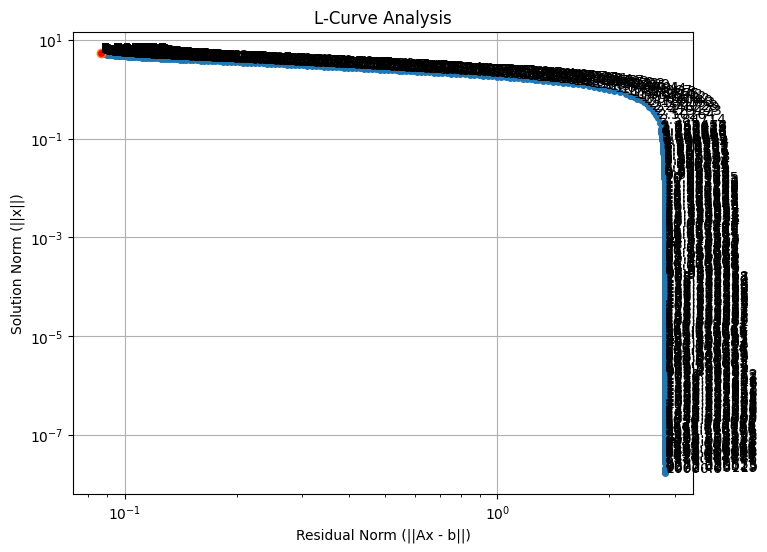

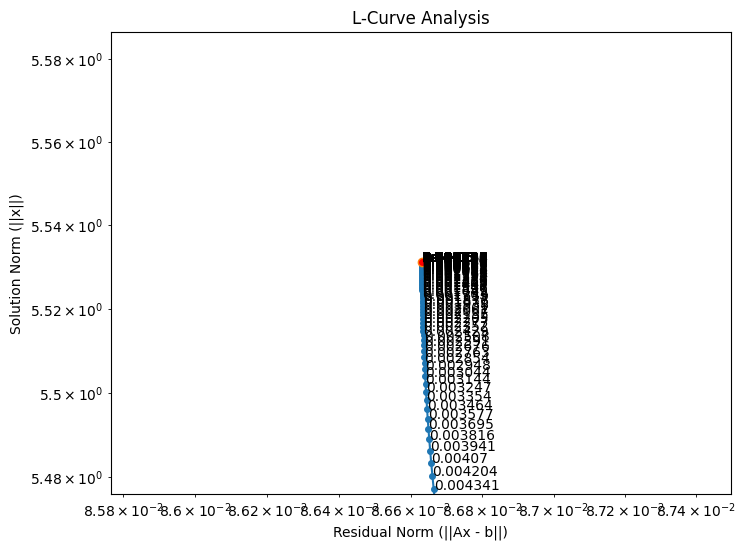

In [7]:
# Residuals
def residuals(params, t, noisy_data):
   c1, T21, c2, T22 = params
   new_data = noisy_data[:-4]
   return new_data - biexponential(t, c1, T21, c2, T22)

lmda_range = np.logspace(-10, 4, 1000)
residual_norms = []
solution_norms = []
noisy_data = d_tilde(y_true, SD)

for lmda in lmda_range:          
   # Fit the model with regularization
   LMDA = lmda
   est_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params, maxfev=40000,
                                             bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
   
   # Calculate the residual and solution norms
   residual_norm = norm(residuals(est_params, t, noisy_data), ord = 2)
   solution_norm = norm(est_params * REG_ARRAY, ord = 2)
   
   residual_norms.append(residual_norm)
   solution_norms.append(solution_norm)

print("lmda_range", lmda_range)
optimal_lmda, opt_idx, kappa = l_curve_corner(np.array(residual_norms), np.array(solution_norms), lmda_range)
print(optimal_lmda)

LMDA = optimal_lmda
optimal_params, _ = curve_fit(G_tilde, t, noisy_data, p0=true_params,  maxfev=40000, bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))

fig, ax = plt.subplots(figsize=(8, 6))
line, = ax.loglog(residual_norms, solution_norms, '-o', markersize=4)
plt.xlabel('Residual Norm (||Ax - b||)')
plt.ylabel('Solution Norm (||x||)')
plt.title('L-Curve Analysis')
plt.grid(True)
for i in range(len(lmda_range)):
    ax.annotate(round(lmda_range[i], 6), (residual_norms[i], solution_norms[i]))
    
# Highlight the optimal point in red
plt.plot(residual_norms[opt_idx], solution_norms[opt_idx], 'o', markerfacecolor='red')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
line, = ax.loglog(residual_norms, solution_norms, '-o', markersize=4)
plt.xlabel('Residual Norm (||Ax - b||)')
plt.ylabel('Solution Norm (||x||)')
plt.title('L-Curve Analysis')
plt.grid(True)

# Annotate all points
for i in range(len(lmda_range)):
    ax.annotate(round(lmda_range[i], 6), (residual_norms[i], solution_norms[i]))

# Highlight the optimal point in red
optimal_x = residual_norms[opt_idx]
optimal_y = solution_norms[opt_idx]
plt.plot(optimal_x, optimal_y, 'o', markerfacecolor='red')

# Set limits to zoom in around the red dot
x_margin = 0.01 * optimal_x  # Adjust this factor as needed
y_margin = 0.01 * optimal_y  # Adjust this factor as needed
plt.xlim(optimal_x - x_margin, optimal_x + x_margin)
plt.ylim(optimal_y - y_margin, optimal_y + y_margin)

plt.show()


## NLLS, no regularization

Noise values: 0.01, 0.1, 0.5 <br>
T2/T1 ratio: 1 (100, 100), 3 (300, 100), 5 (500, 100)

In [5]:
all_c1 = []
all_T21 = []
all_c2 = []
all_T22 = []

for _ in range(NUM_NOISE_REALIZATIONS):
    # Create noisy data and fit parameters  
    noisy_data = gen_noisy_data(y_true, SD)
    scipy_params, params_covariance = curve_fit(biexponential, t, noisy_data, p0=true_params,
                                          bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
    fitted_c1, fitted_T21, fitted_c2, fitted_T22 = scipy_params

    # Store fitted parameters
    all_c1.append(fitted_c1)
    all_T21.append(fitted_T21)
    all_c2.append(fitted_c2)
    all_T22.append(fitted_T22)

In [6]:
c1_mse = calc_mse(true_c1, all_c1)
c1_mean_bias = calc_mean_bias(true_c1, all_c1)
c1_var = np.var(all_c1)

T21_mse = calc_mse(true_T21, all_T21)
T21_mean_bias = calc_mean_bias(true_T21, all_T21)
T21_var = np.var(all_T21)

c2_mse = calc_mse(true_c2, all_c2)
c2_mean_bias = calc_mean_bias(true_c2, all_c2)
c2_var = np.var(all_c2)

T22_mse = calc_mse(true_T22, all_T22)
T22_mean_bias = calc_mean_bias(true_T22, all_T22)
T22_var = np.var(all_T22)

In [ ]:
# Make histograms
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.hist(all_c1, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'C1 values: C1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}')
text = f'MSE = {c1_mse} \nbias = {c1_mean_bias} \nvariance = {c1_var}'
plt.xlim(0.25, 0.75)
plt.text(0.3, 140, text)
plt.axvline(x=true_c1, color='red')

plt.subplot(2, 2, 2)
plt.hist(all_T21, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'T21 values: C1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}')
text = f'MSE = {T21_mse} \nbias = {T21_mean_bias} \nvariance = {T21_var}'
plt.text(200, 125, text)
plt.xlim(50, 600)
plt.axvline(x=true_T21, color='red')

plt.subplot(2, 2, 3)
plt.hist(all_c2, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'C2 values: C1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}')
text = f'MSE = {c2_mse} \nbias = {c2_mean_bias} \nvariance = {c2_var}'
plt.text(0.6, 120, text)
plt.xlim(0.25, 0.75)
plt.axvline(x=true_c2, color='red')

plt.subplot(2, 2, 4)
plt.hist(all_T22, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'T22 values: C1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}')
text = f'MSE = {T22_mse} \nbias = {T22_mean_bias} \nvariance = {T22_var}'
plt.text(100, 150, text)
plt.xlim(50, 600)
plt.axvline(x=true_T22, color='red')

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.hist(all_c1, bins=15, edgecolor='black', linewidth=1.2, alpha=0.5, label=f'C1, Var={round(c1_var, 6)}')
plt.hist(all_c2, bins=15, edgecolor='black', linewidth=1.2, alpha=0.5, label=f'C2, Var={round(c2_var, 6)}')
plt.title(f'C1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}')
plt.axvline(x=true_c1, color='blue', label='True C1')
plt.axvline(x=true_c2, color='orange', label='True C2')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(all_T21, bins=15, edgecolor='black', linewidth=1.2, alpha=0.5, label=f'T21, Var={round(T21_var, 2)}')
plt.hist(all_T22, bins=15, edgecolor='black', linewidth=1.2, alpha=0.5, label=f'T22, Var={round(T22_var, 2)}')
plt.title(f'C1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}')
plt.axvline(x=true_T21, color='blue', label='True T21')
plt.axvline(x=true_T22, color='orange', label='True T22')
plt.legend()

In [ ]:
plt.figure(figsize=(16, 8))
for c1, T21, c2, T22 in zip(all_c1, all_T21, all_c2, all_T22):
    plt.plot(t, biexponential(t, c1, T21, c2, T22), color='red')
plt.plot(t, y_true, color='black')

## Oracle Grid Search

In [ ]:
# One noise realization
lmda_space = np.logspace(-6, 0, 40)
noisy_data = d_tilde(y_true, SD)
errors = []

for x in lmda_space:
    LMDA = x
    scipy_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params,
                                                bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
    error = lambdaError(scipy_params)
    errors.append(error)

min_pos = errors.index(min(errors))
best_lmda = lmda_space[min_pos]

LMDA = best_lmda
scipy_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params,
                                            bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
oracle_c1, oracle_T21, oracle_c2, oracle_T22 = scipy_params

print('Best oracle lambda:', best_lmda)
print('Best C1:', oracle_c1)
print('Best T21:', oracle_T21)

In [ ]:
# 1000 NRs
lmda_space = np.logspace(-6, 0, 40)
oracle_lmdas = []
oracle_c1s = []
oracle_T21s = []
oracle_c2s = []
oracle_T22s = []

for _ in range(1001):
    # Create noisy data
    noisy_data = d_tilde(y_true, SD)
    errors = []
    curr_c1s = []
    curr_T21s = []
    curr_c2s = []
    curr_T22s = []

    for x in lmda_space:
        LMDA = x
        scipy_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params,
                                                    bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
        error = lambdaError(scipy_params)
        errors.append(error)
    
    min_pos = errors.index(min(errors))
    best_lmda = lmda_space[min_pos]
    center = np.log10(best_lmda)
    width = 2
    new_lmda_space = np.logspace(center - width, center + width, 40)
    new_errors = []

    for x in new_lmda_space:
        LMDA = x
        scipy_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params,
                                                    bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
        error = lambdaError(scipy_params)
        new_errors.append(error)
    
    new_min_pos = new_errors.index(min(new_errors))
    new_best_lmda = new_lmda_space[new_min_pos]

    LMDA = new_best_lmda
    optimal_params, _ = curve_fit(G_tilde, t, noisy_data, p0=true_params, 
                                    bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
    oracle_lmdas.append(new_best_lmda)
    oracle_c1s.append(optimal_params[0])
    oracle_T21s.append(optimal_params[1])
    oracle_c2s.append(optimal_params[2])
    oracle_T22s.append(optimal_params[3])

In [ ]:
plt.hist(oracle_lmdas, edgecolor='black', linewidth=1.2)
plt.title(f'Lambda Dist Using Oracle:\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')

In [ ]:
oracle_c1_mse = calc_mse(true_c1, oracle_c1s)
oracle_c1_mean_bias = calc_mean_bias(true_c1, oracle_c1s)
oracle_c1_var = np.var(oracle_c1s)

In [ ]:
# Make histograms
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.hist(oracle_c1s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'C1 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
text = f'MSE = {c1_mse} \nbias = {c1_mean_bias} \nvariance = {c1_var}'
#plt.xlim(0.25, 0.75)
#plt.text(0.3, 140, text)
plt.axvline(x=true_c1, color='red')

plt.subplot(2, 2, 2)
plt.hist(oracle_T21s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'T21 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
text = f'MSE = {T21_mse} \nbias = {T21_mean_bias} \nvariance = {T21_var}'
#plt.text(200, 125, text)
#plt.xlim(50, 600)
plt.axvline(x=true_T21, color='red')

plt.subplot(2, 2, 3)
plt.hist(oracle_c2s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'C2 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
text = f'MSE = {c2_mse} \nbias = {c2_mean_bias} \nvariance = {c2_var}'
#plt.text(0.6, 120, text)
#plt.xlim(0.25, 0.75)
plt.axvline(x=true_c2, color='red')

plt.subplot(2, 2, 4)
plt.hist(oracle_T22s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'T22 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
text = f'MSE = {T22_mse} \nbias = {T22_mean_bias} \nvariance = {T22_var}'
#plt.text(100, 150, text)
#plt.xlim(50, 600)
plt.axvline(x=true_T22, color='red')

## L-curve

One noise realization

In [3]:
REG_ARRAY

array([1.  , 0.01, 1.  , 0.01])

In [6]:
# Residuals
def residuals(params, t, noisy_data):
   c1, T21, c2, T22 = params
   new_data = noisy_data[:-4]
   return new_data - biexponential(t, c1, T21, c2, T22)

lmda_range = np.append(0, np.logspace(-20, 1, 1000))
residual_norms = []
solution_norms = []
noisy_data = d_tilde(y_true, SD)

for lmda in lmda_range:          
   # Fit the model with regularization
   LMDA = lmda
   est_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params, maxfev=40000,
                                             bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
   
   # Calculate the residual and solution norms
   residual_norm = norm(residuals(est_params, t, noisy_data), ord = 2)
   solution_norm = norm(est_params * REG_ARRAY, ord = 2)
   
   residual_norms.append(residual_norm)
   solution_norms.append(solution_norm)

optimal_lmda, opt_idx, kappa = l_curve_corner(np.array(residual_norms), np.array(solution_norms), lmda_range)
print(optimal_lmda)

LMDA = optimal_lmda
optimal_params, _ = curve_fit(G_tilde, t, noisy_data, p0=true_params,  maxfev=40000, bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))

fig, ax = plt.subplots(figsize=(8, 6))
line, = ax.loglog(residual_norms, solution_norms, '-o', markersize=4)
plt.xlabel('Residual Norm (||Ax - b||)')
plt.ylabel('Solution Norm (||x||)')
plt.title('L-Curve Analysis')
plt.grid(True)
for i in range(len(lmda_range)):
    ax.annotate(round(lmda_range[i], 6), (residual_norms[i], solution_norms[i]))
    
# Highlight the optimal point in red
plt.plot(residual_norms[opt_idx], solution_norms[opt_idx], 'o', markerfacecolor='red')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
line, = ax.loglog(residual_norms, solution_norms, '-o', markersize=4)
plt.xlabel('Residual Norm (||Ax - b||)')
plt.ylabel('Solution Norm (||x||)')
plt.title('L-Curve Analysis')
plt.grid(True)

# Annotate all points
for i in range(len(lmda_range)):
    ax.annotate(round(lmda_range[i], 6), (residual_norms[i], solution_norms[i]))

# Highlight the optimal point in red
optimal_x = residual_norms[opt_idx]
optimal_y = solution_norms[opt_idx]
plt.plot(optimal_x, optimal_y, 'o', markerfacecolor='red')

# Set limits to zoom in around the red dot
x_margin = 0.5 * optimal_x  # Adjust this factor as needed
y_margin = 0.5 * optimal_y  # Adjust this factor as needed
plt.xlim(optimal_x - x_margin, optimal_x + x_margin)
plt.ylim(optimal_y - y_margin, optimal_y + y_margin)

plt.show()

# Plot the L-curve (Residual Norm vs Solution Norm)

# print('Optimal L-curve lambda: ', optimal_lmda)
# print('Optimal c1: ', optimal_params[0])
# print('Optimal T21: ', optimal_params[1])
# print('Optimal c2: ', optimal_params[2])
# print('Optimal T22: ', optimal_params[3])

second update
0.0


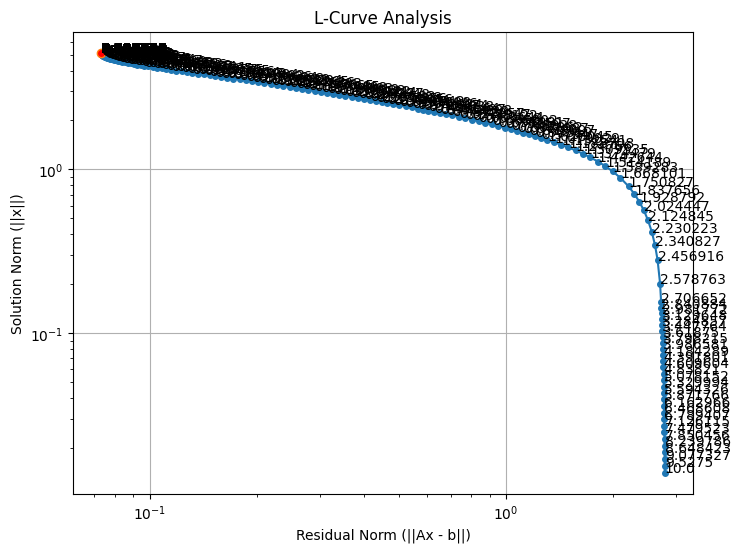

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
line, = ax.loglog(residual_norms, solution_norms, '-o', markersize=4)
plt.xlabel('Residual Norm (||Ax - b||)')
plt.ylabel('Solution Norm (||x||)')
plt.title('L-Curve Analysis')
plt.grid(True)
for i in range(len(lmda_range)):
    ax.annotate(round(lmda_range[i], 6), (residual_norms[i], solution_norms[i]))
    
# Highlight the optimal point in red
plt.plot(residual_norms[opt_idx], solution_norms[opt_idx], 'o', markerfacecolor='red')
plt.show()



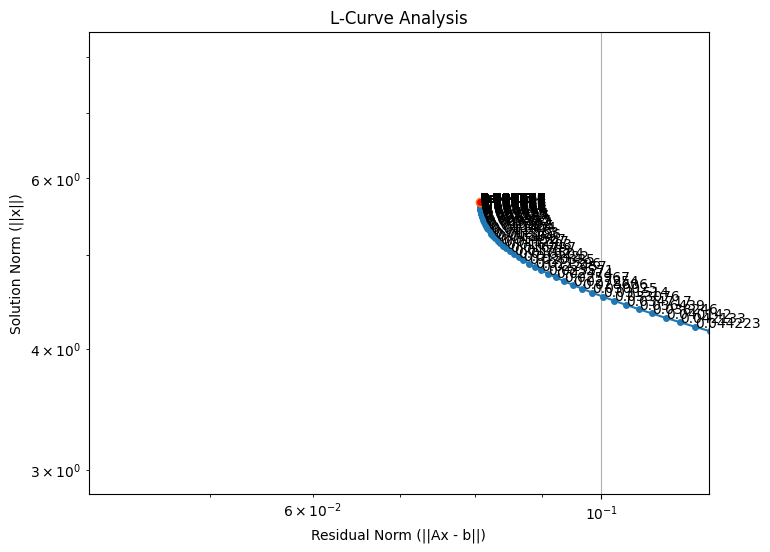

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
line, = ax.loglog(residual_norms, solution_norms, '-o', markersize=4)
plt.xlabel('Residual Norm (||Ax - b||)')
plt.ylabel('Solution Norm (||x||)')
plt.title('L-Curve Analysis')
plt.grid(True)

# Annotate all points
for i in range(len(lmda_range)):
    ax.annotate(round(lmda_range[i], 6), (residual_norms[i], solution_norms[i]))

# Highlight the optimal point in red
optimal_x = residual_norms[opt_idx]
optimal_y = solution_norms[opt_idx]
plt.plot(optimal_x, optimal_y, 'o', markerfacecolor='red')

# Set limits to zoom in around the red dot
x_margin = 0.5 * optimal_x  # Adjust this factor as needed
y_margin = 0.5 * optimal_y  # Adjust this factor as needed
plt.xlim(optimal_x - x_margin, optimal_x + x_margin)
plt.ylim(optimal_y - y_margin, optimal_y + y_margin)

plt.show()


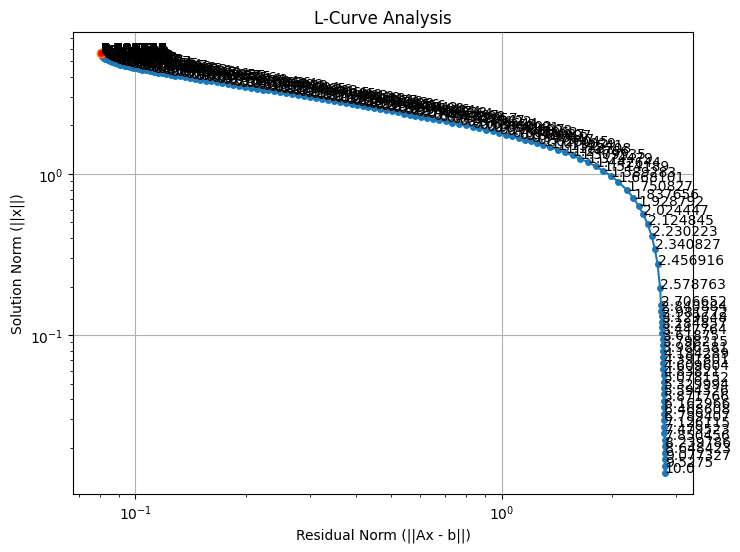

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
line, = ax.loglog(residual_norms, solution_norms, '-o', markersize=4)
plt.xlabel('Residual Norm (||Ax - b||)')
plt.ylabel('Solution Norm (||x||)')
plt.title('L-Curve Analysis')
plt.grid(True)
for i in range(len(lmda_range)):
   ax.annotate(round(lmda_range[i], 6), (residual_norms[i], solution_norms[i]))
   if i == opt_idx:
      plt.plot(residual_norms[i], solution_norms[i], 'o', markerfacecolor='red')
plt.show()


In [27]:
p = bokeh.plotting.figure(
    title="L-curve Interactive", 
    x_axis_label='Residual Norms',
    y_axis_label='Solution Norms',
    x_axis_type="log",
    y_axis_type="log"
)
p.line(residual_norms, solution_norms, line_width=2)
circle = p.scatter(
    residual_norms[opt_idx],
    solution_norms[opt_idx],
    marker="circle",
    size=5,
    fill_color="red",
)
bokeh.io.show(p)

NameError: name 'bokeh' is not defined

Multiple noise realizations

In [72]:
# Residuals
def residuals(params, t, noisy_data):
   c1, T21, c2, T22 = params
   new_data = noisy_data[:-4]
   return new_data - biexponential(t, c1, T21, c2, T22)

lmda_range = np.logspace(-8, -6, 200)
lcurve_lmdas = []
lcurve_c1s = []
lcurve_T21s = []
lcurve_c2s = []
lcurve_T22s = []

for _ in range(1001):
   residual_norms = []
   solution_norms = []
   noisy_data = d_tilde(y_true, SD)

   for lmda in lmda_range:          
      # Fit the model with regularization
      LMDA = lmda
      est_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params,
                                                bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
      
      # Calculate the residual and solution norms
      residual_norm = norm(residuals(est_params, t, noisy_data))
      solution_norm = norm(est_params)

      # Average residual and solution norms over all realizations for this alpha
      residual_norms.append(residual_norm)
      solution_norms.append(solution_norm)

   optimal_lmda, opt_idx, kappa = l_curve_corner(np.array(residual_norms), np.array(solution_norms), lmda_range)

   LMDA = optimal_lmda
   optimal_params, _ = curve_fit(G_tilde, t, noisy_data, p0=true_params, 
                                 bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
   lcurve_lmdas.append(optimal_lmda)
   lcurve_c1s.append(optimal_params[0])
   lcurve_T21s.append(optimal_params[1])
   lcurve_c2s.append(optimal_params[2])
   lcurve_T22s.append(optimal_params[3])

In [ ]:
plt.hist(lcurve_lmdas, bins=20, edgecolor='black')
plt.title(f'Lambda Distribution Using L-Curve\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
print(lcurve_lmdas)

In [ ]:
lcurve_c1_mse = calc_mse(true_c1, lcurve_c1s)
lcurve_c1_mean_bias = calc_mean_bias(true_c1, lcurve_c1s)
lcurve_c1_var = np.var(lcurve_c1s)
print('MSE:', lcurve_c1_mse)
print('Mean bias:', lcurve_c1_mean_bias)
print('Variance:', lcurve_c1_var)

In [ ]:
# Make histograms
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.hist(lcurve_c1s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'L-curve C1 values:\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
plt.axvline(x=true_c1, color='red')

plt.subplot(2, 2, 2)
plt.hist(lcurve_T21s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'L-curve T21 values:\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
plt.axvline(x=true_T21, color='red')

plt.subplot(2, 2, 3)
plt.hist(lcurve_c2s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'L-curve C2 values:\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
plt.axvline(x=true_c2, color='red')

plt.subplot(2, 2, 4)
plt.hist(lcurve_T22s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'L-curve T22 values:\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
plt.axvline(x=true_T22, color='red')

## GCV

In [139]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

In [ ]:
# Jacobian matrix
def J(t, c1, c2, T21, T22):
    func1 = np.exp(-t/T21)
    func2 = np.exp(-t/T22)
    func3 = (c1*t)*np.exp(-t/T21)/(T21**2)
    func4 = (c2*t)*np.exp(-t/T22)/(T22**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    return jacobian

# GCV score
def get_GCV_value(params, RSS, lamb):
    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    GCVjacobian = J(t, *params)
    if (lamb < 1e-7):
        GCVdenominator = len(t) - np.linalg.matrix_rank(GCVjacobian)
    else:
        C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(lamb**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
        (n,n) = C_GCV.shape
        identity = np.identity(n)
        GCVdenominator = (identity - C_GCV).trace()
    GCV = RSS/(GCVdenominator**2)
    return GCV

# Residual sum of squares
def RSS(params):
    rss = 0
    true_data = biexponential(t, *true_params)
    est_data = biexponential(t, *params)
    for true, est in zip(true_data, est_data):
        rss += (true - est) ** 2
    return rss

lmda_range = np.logspace(-6, -1, 100)
gcv_scores = []

for lmda in lmda_range:         
    # Fit the model with regularization
    LMDA = lmda
    est_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params,
                                            bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
    
    # Calculate GCV scores
    rss = RSS(est_params)
    gcv_score = get_GCV_value(est_params, rss, lmda)
    gcv_scores.append(gcv_score)

min_pos = gcv_scores.index(min(gcv_scores))
optimal_lmda = lmda_range[min_pos]

LMDA = optimal_lmda
optimal_params, _ = curve_fit(G_tilde, t, noisy_data, p0=true_params, 
                              bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))

print('C1:', optimal_params[0])
print('T21:', optimal_params[1])
print('C2:', optimal_params[2])
print('T22:', optimal_params[3])
print('Optimal GCV Lambda:', optimal_lmda)

# Plot the GCV curve (Lambda vs GCV Scores)
fig, ax = plt.subplots(figsize=(16, 16))
line, = ax.plot(lmda_range, gcv_scores, '-o', markersize=4)
plt.xlabel('Lamda')
plt.ylabel('GCV Score')
plt.title('GCV Scores for Lambda Values')
for i in range(len(lmda_range)):
   ax.annotate(lmda_range[i], (lmda_range[i], gcv_scores[i]))
   if lmda_range[i] == optimal_lmda:
      plt.plot(lmda_range[i], gcv_scores[i], 'o', markerfacecolor='red')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
line, = ax.plot(lmda_range[:75], gcv_scores[:75], '-o', markersize=4)
plt.xlabel('Lamda')
plt.ylabel('GCV Score')
plt.title('GCV Scores for Lambda Values')
for i in range(75):
   ax.annotate(round(lmda_range[i], 4), (lmda_range[i], gcv_scores[i]))
   if lmda_range[i] == optimal_lmda:
      plt.plot(lmda_range[i], gcv_scores[i], 'o', markerfacecolor='red')

In [ ]:
p = bokeh.plotting.figure(
    title="GCV Curve Interactive", 
    x_axis_label='Lambda',
    y_axis_label='GCV Score'
)
p.line(lmda_range[:75], gcv_scores[:75], line_width=2)
opt_idx = np.where(lmda_range == optimal_lmda)[0][0]
circle = p.scatter(
    lmda_range[opt_idx],
    gcv_scores[opt_idx],
    marker="circle",
    size=5,
    fill_color="red",
)
bokeh.io.show(p)

In [100]:
lmda_range = np.logspace(-6, -1, 100)
gcv_lmdas = []
gcv_c1s = []
gcv_T21s = []
gcv_c2s = []
gcv_T22s = []

for _ in range(1001):
    noisy_data = d_tilde(y_true, SD)
    gcv_scores = []

    for lmda in lmda_range:         
        LMDA = lmda
        est_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params,
                                                bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
        
        # Calculate GCV scores
        rss = RSS(est_params)
        gcv_score = get_GCV_value(est_params, rss, lmda)

        gcv_scores.append(gcv_score)
        
    min_pos = gcv_scores.index(min(gcv_scores))
    optimal_lmda = lmda_range[min_pos]

    LMDA = optimal_lmda
    optimal_params, _ = curve_fit(G_tilde, t, noisy_data, p0=true_params, 
                                  bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
    gcv_lmdas.append(optimal_lmda)
    gcv_c1s.append(optimal_params[0])
    gcv_T21s.append(optimal_params[1])
    gcv_c2s.append(optimal_params[2])
    gcv_T22s.append(optimal_params[3])

In [ ]:
# Make histograms
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.hist(gcv_c1s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'GCV C1 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
text = f'MSE = {c1_mse} \nbias = {c1_mean_bias} \nvariance = {c1_var}'
#plt.xlim(0.25, 0.75)
#plt.text(0.3, 140, text)
plt.axvline(x=true_c1, color='red')

plt.subplot(2, 2, 2)
plt.hist(gcv_T21s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'GCV T21 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
text = f'MSE = {T21_mse} \nbias = {T21_mean_bias} \nvariance = {T21_var}'
#plt.text(200, 125, text)
#plt.xlim(50, 600)
plt.axvline(x=true_T21, color='red')

plt.subplot(2, 2, 3)
plt.hist(gcv_c2s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'GCV C2 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
text = f'MSE = {c2_mse} \nbias = {c2_mean_bias} \nvariance = {c2_var}'
#plt.text(0.6, 120, text)
#plt.xlim(0.25, 0.75)
plt.axvline(x=true_c2, color='red')

plt.subplot(2, 2, 4)
plt.hist(gcv_T22s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'GCV T22 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
text = f'MSE = {T22_mse} \nbias = {T22_mean_bias} \nvariance = {T22_var}'
#plt.text(100, 150, text)
#plt.xlim(50, 600)
plt.axvline(x=true_T22, color='red')

## Discrepancy Principle

Keep track of lamdas and perform regularization to get p_lambda (parameters for each lambda) <br>
Calculate residuals (np.linalg.norm(G * p_lambda - noisy_data)) <br>
See which residual is closest to threshold value, threshold = np.linalg.norm(noise * safety_factor=1.05), 
select noise from Gaussian dist (np.sqrt(4 * ))

In [ ]:
# Residuals function
def residual(params, t, noisy_data):
   c1, T21, c2, T22 = params
   new_data = noisy_data[:-4]
   return np.linalg.norm(biexponential(t, c1, T21, c2, T22) - new_data)

lmda_space = np.logspace(-6, 0, 40)
disc_lmdas = []

# Define threshold value
n = len(t)
safety_fact = 1.05
sigma_ep = np.max(noisy_data) / SNR
threshold = np.linalg.norm(safety_fact * np.sqrt(n) * sigma_ep)

# Create noisy data
noisy_data = d_tilde(y_true, SD)
residuals = []
res_thres = []
all_params = []

for x in lmda_space:
    LMDA = x
    scipy_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params,
                                                bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
    res = residual(scipy_params, t, noisy_data)
    residuals.append(res)
    res_thres.append(res - threshold)
    all_params.append(scipy_params)

min_pos = res_thres.index(min(res_thres))
best_lmda = lmda_space[min_pos]
fitted_params = all_params[min_pos]

# Display fitted parameters
print("Fitted Parameters:")
print("c1 =", fitted_params[0])
print("T21 =", fitted_params[1])
print("c2 =", fitted_params[2])
print("T22 =", fitted_params[3])

# Plot lambda vs residuals
plt.figure()
plt.loglog(lmda_space, residuals)
plt.axhline(threshold, color='red', label='Threshold')
plt.xlabel('Lambda')
plt.ylabel('Residual')
plt.legend()

# Plot the results
plt.figure()
plt.plot(t, noisy_data[:-4], 'o', label="Observed Data")
plt.plot(t, y_true, '--', label="True Model", alpha=0.7)
plt.plot(t, biexponential(t, *fitted_params), label="Fitted Model")
plt.legend()
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Biexponential Fitting with Discrepancy Principle')
plt.show()

In [146]:
# Residuals function
def residual(params, t, noisy_data):
   c1, T21, c2, T22 = params
   new_data = noisy_data[:-4]
   return np.linalg.norm(biexponential(t, c1, T21, c2, T22) - new_data)

lmda_space = np.logspace(-6, 0, 40)
disc_lmdas = []
disc_c1s = []
disc_T21s = []
disc_c2s = []
disc_T22s = []

# Define threshold value
n = len(t)
safety_fact = 1.05
sigma_ep = np.max(noisy_data) / SNR
threshold = np.linalg.norm(safety_fact * np.sqrt(n) * sigma_ep)

for _ in range(1001):
    # Create noisy data
    noisy_data = d_tilde(y_true, SD)
    res_thres = []
    curr_c1s = []
    curr_T21s = []
    curr_c2s = []
    curr_T22s = []

    for x in lmda_space:
        LMDA = x
        scipy_params, params_covariance = curve_fit(G_tilde, t, noisy_data, p0=true_params,
                                                    bounds=([0, 0, 0, 0], [1, np.inf, 1, np.inf]))
        res = residual(scipy_params, t, noisy_data)
        res_thres.append(res - threshold)
        curr_c1s.append(scipy_params[0])
        curr_T21s.append(scipy_params[1])
        curr_c2s.append(scipy_params[2])
        curr_T22s.append(scipy_params[3])
    
    min_pos = res_thres.index(min(res_thres))
    best_lmda = lmda_space[min_pos]
    fitted_c1 = curr_c1s[min_pos]
    fitted_T21 = curr_T21s[min_pos]
    fitted_c2 = curr_c2s[min_pos]
    fitted_T22 = curr_T22s[min_pos]
    
    disc_lmdas.append(best_lmda)
    disc_c1s.append(fitted_c1)
    disc_T21s.append(fitted_T21)
    disc_c2s.append(fitted_c2)
    disc_T22s.append(fitted_T22)

In [ ]:
plt.hist(disc_c1s, edgecolor='black', linewidth=1.2)
plt.xlabel('C1')
plt.ylabel('Frequency')
plt.title(f'C1 Distribution Using Discrepancy Principle\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
plt.axvline(x=true_c1, color='red')

In [ ]:
# Make histograms
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.hist(disc_c1s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'Discrepancy C1 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
plt.axvline(x=true_c1, color='red')

plt.subplot(2, 2, 2)
plt.hist(disc_T21s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'Discrepancy T21 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
plt.axvline(x=true_T21, color='red')

plt.subplot(2, 2, 3)
plt.hist(disc_c2s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'Discrepancy C2 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
plt.axvline(x=true_c2, color='red')

plt.subplot(2, 2, 4)
plt.hist(disc_T22s, bins=15, edgecolor='black', linewidth=1.2)
plt.title(f'Discrepancy T22 values\nC1={true_c1}, T21={true_T21}, C2={true_c2}, T22={true_T22}\nSNR={SNR}')
plt.axvline(x=true_T22, color='red')